# Allgemein

Ablauf:

1.   Daten einlesen: \
     Die Daten werden von Google Drive eingelesen und in einen lokalen Ordner kopiert. Ggf. werden Dateinamen korrigiert um Probleme mit Libaries vorzubeugen.
2.   Datenaufbereitung: \
     Die Daten werden vor dem Training in 4 sekündige Ausschnitte unterteilt. Für jeden Abschnitt wir die Grundfreqenz mit [CREPE](http://github.com/marl/crepe) und die Lautstärk extrahiert. Gespeichert wird dies als [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord)-Datei für zukünftige Trainings.
3.   Training: \
     Im Training wird die Modellarchitektur implementiert, wobei zwei verschiedene Architekturen möglich sind. Ein RNN mit zusätzlichem fully connected layer und ein dialeted convolution decoder. Letzterer wird in der Ababe nicht verwendet. Des Weiteren wird der Trainingsloop durchgeführt und der Fortschritt mit [Weights & Biases](https://wandb.ai/site) aufgezeichnet.


# Installation

In [ ]:
#@markdown 1. Diese Zelle zuerst ausführen für die Installation von bestimmten Versionen von Dependencies. Im Anschluss, wie vorgeschlagen, die Session neu starten. \
#@markdown (Es wird einige wenige, nicht kompatible Pakete geben. Diese werden aber nicht verwendet. Dauer ~1-3min)

!pip uninstall -y keras tensorflow tensorflow-probability absl-py astunparse flatbuffers gast google-pasta grpcio h5py keras keras-preprocessing libclang numpy opt-einsum protobuf setuptools six tensorboard tensorflow-io-gcs-filesystem termcolor tf-estimator-nightly typing-extensions wrapt
!pip install --disable-pip-version-check --no-cache-dir tensorflow==2.11.0
!pip install tensorflow-probability==0.15.0
!pip install keras==2.11.0

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-probability 0.22.0
Uninstalling tensorflow-probability-0.22.0:
  Successfully uninstalled tensorflow-probability-0.22.0
Found existing installation: absl-py 1.4.0
Uninstalling absl-py-1.4.0:
  Successfully uninstalled absl-py-1.4.0
Found existing installation: astunparse 1.6.3
Uninstalling astunparse-1.6.3:
  Successfully uninstalled astunparse-1.6.3
Found existing installation: flatbuffers 23.5.26
Uninstalling flatbuffers-23.5.26:
  Successfully uninstalled flatbuffers-23.5.26
Found existing installation: gast 0.5.4
Uninstalling gast-0.5.4:
  Successfully uninstalled gast-0.5.4
Found existing installation: google-pasta 0.2.0
Uninstalling google-pasta-0.2.0:
  Successfully uninstalled google-pasta-0.2.0
Found existing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 55.5 MB/s eta 0:00:00


In [ ]:
#@markdown 2. Im Anschluss die Libary DDSP installieren und die Session wieder neustarten. \
#@markdown (Dauer ~2-3min)

!sudo apt-get install libportaudio2
!pip install -U ddsp[data_preparation]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 1s (90.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 121671 fi

Session neu starten. \\
Installiere weights and biases für das Aufzeichnen des Trainingsfortschritts.

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.8 MB/s eta 0:00:00


Einloggen in weights and biases.


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Die Importe sollten problemlos durchlaufen.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import datetime
import glob
import os

import tensorflow as tf
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

from ddsp.colab import colab_utils
import ddsp.training
from ddsp.training import (data, decoders, encoders, models, preprocessing,
                           train_util, trainers, metrics, nn)

# 16000 is the default sample rate of ddsp.
sample_rate = colab_utils.DEFAULT_SAMPLE_RATE

# Daten einlesen

Wir verwenden Google-Drive für die Trainingsdaten und das Zwischenspeichern von Checkpoints. Die Trainingsdaten werden in einen lokalen Ordner kopiert und dort verarbeitet. Wichtige Daten, wie vorverarbeitete Trainingsdaten und Checkpoints, werden zur Sicherung ins Drive kopiert.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@markdown Google Drive Ordner mit mp3/wav Trainingsdaten (Beispielordner: `/content/drive/MyDrive/...`)
DRIVE_DIR = '/content/drive/MyDrive/duesi' #@param {type: "string"}

assert os.path.exists(DRIVE_DIR)
print('Drive Folder Exists:', DRIVE_DIR)

Drive Folder Exists: /content/drive/MyDrive/duesi


# 2. Datenaufbereitung

Lade/Erstelle den Datensatz. Das Laden von einem bestehenden Datensatz geht schnell. Das Vorverarbeiten für einen neuen Datensatz dauert etwa 2 Stunden pro 10 Minuten Trainingsaudio.

Bei der Verarbeitung werden sehr wahrscheinlich einige Warnungen ausgegeben. Dabei handelt es sich um stille Abschnitte der Audiodatei mit einer Lautstärke von 0. Diese werden bei der Aufbereitung herausgefiltert.

In [ ]:
# Make dir for saving the checkpoints.
SAVE_DIR = os.path.join(DRIVE_DIR, 'model')
!mkdir -p "$SAVE_DIR"

phases = ['train', 'val', 'test']
# Dataset for each phase.
dataset = {}

for phase in phases:
    PHASE_DRIVE_DIR = os.path.join(DRIVE_DIR, phase)

    # Make local directories.
    AUDIO_DIR = os.path.join(phase, 'data/audio')
    AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
    !mkdir -p $AUDIO_DIR

    mp3_files = glob.glob(os.path.join(PHASE_DRIVE_DIR, '*.mp3'))
    wav_files = glob.glob(os.path.join(PHASE_DRIVE_DIR, '*.wav'))
    audio_files = mp3_files + wav_files

    print(PHASE_DRIVE_DIR)

    for file_name in audio_files:
        target_name = os.path.join(AUDIO_DIR, os.path.basename(file_name).replace(' ', '_'))
        print('Copying {} to {}'.format(file_name, target_name))
        !cp "$file_name" $target_name

    TFRECORD = os.path.join(phase, 'data/train.tfrecord')
    TFRECORD_FILEPATTERN = TFRECORD + '*'

    # Copy dataset from drive if dataset has already been created.
    drive_data_dir = os.path.join(PHASE_DRIVE_DIR, 'data')
    drive_dataset_files = glob.glob(drive_data_dir + '/*')

    # Find already processed dataset on drive.
    if len(drive_dataset_files) > 0:
        print(f"Found {phase} dataset in Drive. Copying to local files...")
        TARGET = os.path.join(phase, 'data')
        !cp "$drive_data_dir"/* $TARGET/

    # Else create new Dataset.
    else:
        if not glob.glob(AUDIO_FILEPATTERN):
            raise ValueError(f'No audio files found in {AUDIO_FILEPATTERN}!')

        !ddsp_prepare_tfrecord \
            --input_audio_filepatterns=$AUDIO_FILEPATTERN \
            --output_tfrecord_path=$TFRECORD \
            --num_shards=10 \
            --alsologtostderr

        # Copy dataset to drive for safe-keeping.
        if DRIVE_DIR:
            !mkdir "$drive_data_dir"/
            print('Saving to {}'.format(drive_data_dir))
            !cp $TFRECORD_FILEPATTERN "$drive_data_dir"/

    data_provider = ddsp.training.data.TFRecordProvider(TFRECORD_FILEPATTERN)
    dataset[phase] = data_provider.get_dataset(shuffle=True)

/content/drive/MyDrive/duesi/train
Found train dataset in Drive. Copying to local files...
/content/drive/MyDrive/duesi/val
Found val dataset in Drive. Copying to local files...
/content/drive/MyDrive/duesi/test
Found test dataset in Drive. Copying to local files...


Ansicht eines vier Sekunden langen Audioabschnittes der Trainingsdaten:

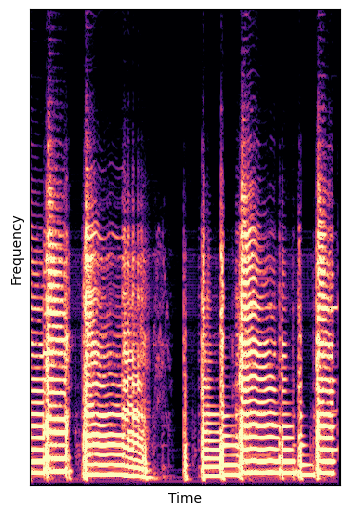

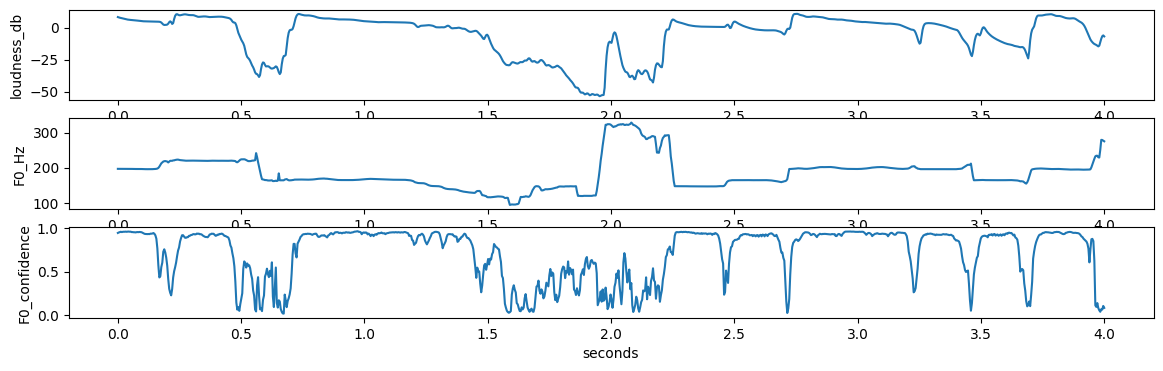

In [ ]:
try:
    ex = next(iter(dataset['train']))
except StopIteration:
    raise ValueError('Error with the Dataset!')

# Save some data for the model creation.
n_samples = len(ex['audio'])
n_time_steps = len(ex['loudness_db'])


colab_utils.specplot(ex['audio'])
colab_utils.play(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])

# Training Vorbereitung
In der Vorbereitung werden die Modellklassen und das Modell definiert sowie die Modellparameter geladen, um alles für das Training vorzubereiten.

## Das Modell

In [ ]:
strategy = train_util.get_strategy()
learning_rate = 1e-3
tfkl = tf.keras.layers

## RNN-Fully Connected-Decoder
Hierbei handelt es sich um ein RNN mit zusätzlichem fully connected layer (FC)
am Ende für passende Outputs. In der Praxis erweisen sich gated recurrent units (gru) als performater im Verleich zu einem LSTM.

In [ ]:
class RnnFcDecoder(nn.DictLayer):

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled', 'z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               **kwargs):
    # Args:
    #   rnn_channels: number of dimensions for RNN layer
    #   rnn_type: 'lstm' or 'gru'
    #   ch: number of dimensions for fully connected layer
    #   layers_per_stack: number of fully connected layers per stack
    #   input_keys: create a fully connected stack for each input
    #   output_splits: splits the outputs into these dimensions
    #   **kwwargs: keras-specific kwargs

    # Returns:
    #   dictionary with keys from output_splits

    # Always put state as the last input and output.
    self.output_splits = output_splits
    output_keys = [v[0] for v in output_splits]

    super().__init__(input_keys=input_keys, output_keys=output_keys, **kwargs)

    stack = lambda: nn.FcStack(ch, layers_per_stack)
    n_stacks = len(self.input_keys)

    rnn_cls = nn.Rnn

    # Layers:
    self.input_stacks = [stack() for _ in range(n_stacks)]
    self.rnn = rnn_cls(rnn_channels, rnn_type)
    self.out_stack = stack()

    n_out = sum([v[1] for v in output_splits])
    self.dense_out = tfkl.Dense(n_out)

  def call(self, *inputs, **unused_kwargs):
    inputs = list(inputs)

    # Initial processing.
    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run RNN.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)
    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    x = self.out_stack(x)
    x = self.dense_out(x)

    output_dict = nn.split_to_dict(x, self.output_splits)

    return output_dict

## Dilated Convolutions
Hierbei handelt es sich um einen Decoder mit dilated convolution. Die Architektur ähnelt WaveNet mit zusätzlicher eindimenseonaler dilated convolution. Dilated bedeutet hier, dass die Größen der Lücken im Kernel mit jeder Schicht exponentiell zunehmen. \\
Im abgegebenen Modell wird diese Architektur *nicht* verwendet.

In [ ]:
class DilatedConvDecoder(nn.OutputSplitsLayer):

  def __init__(self,
               ch=256,
               kernel_size=3,
               layers_per_stack=5,
               stacks=2,
               dilation=2,
               norm_type='layer',
               resample_stride=1,
               stacks_per_resample=1,
               resample_after_convolve=True,
               input_keys=('ld_scaled', 'f0_scaled'),
               output_splits=(('amps', 1), ('harmonic_distribution', 60)),
               spectral_norm=False,
               ortho_init=False,
               **kwargs):
    # Args:
    #   ch: number of channels in each convolution layer
    #   layers_per_stack: number of convolution layers in each 'stack', dilation increases
    #     exponentially with layer depth inside a stack
    #   stacks: number of convolutions stacks
    #   kernel_size: size of convolution kernel
    #   dilation: exponent base of dilation factor within a stack
    #   norm_type: type of normalization before each nonlinearity, choose from
    #     'layer', 'instance', or 'group'
    #   resample_type: whether to 'upsample' or 'downsample' the signal
    #   resample_stride: stride for upsample or downsample layers
    #   stacks_per_resample: number of stacks per a resample layer
    #   resample_after_convolve: ordering of convolution and resampling; if True,
    #     apply 'stacks_per_resample' stacks of convolution then a resampling
    #     layer; Iif False, apply the opposite order
    #   spectral_norm: apply spectral normalization to the convolution weights
    #   ortho_init: orthogonally initialize the kernel weights
    #   **kwwargs: keras-specific kwargs

    input_keys = list(input_keys)
    super().__init__(input_keys, output_splits, **kwargs)


    # Layers.
    self.dilated_conv_stack = tf.keras.Sequential([
        nn.DilatedConvStack(
            ch=ch,
            kernel_size=kernel_size,
            layers_per_stack=layers_per_stack,
            stacks=stacks//2,
            dilation=dilation,
            norm_type=norm_type,
            resample_type='upsample' if resample_stride > 1 else None,
            resample_stride=resample_stride,
            stacks_per_resample=stacks_per_resample,
            resample_after_convolve=resample_after_convolve,
            spectral_norm=spectral_norm,
            ortho_init=ortho_init),
        tfkl.ReLU(),
        nn.DilatedConvStack(
            ch=ch,
            kernel_size=kernel_size,
            layers_per_stack=layers_per_stack,
            stacks=stacks//2,
            dilation=dilation,
            norm_type=norm_type,
            resample_type='upsample' if resample_stride > 1 else None,
            resample_stride=resample_stride,
            stacks_per_resample=stacks_per_resample,
            resample_after_convolve=resample_after_convolve,
            spectral_norm=spectral_norm,
            ortho_init=ortho_init),
        tfkl.ReLU()
    ])

  def _parse_inputs(self, inputs):
      return tf.concat(inputs, axis=-1)

  def compute_output(self, *inputs):
        stack_inputs = self._parse_inputs(inputs)
        return self.dilated_conv_stack(stack_inputs)

## Modell aufsetzen
Hier wird das Modell aufgesetzt, wo die Hyperparameter des Netzes variiert werden können.

In [ ]:
# Rescaling of loudness.
preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=n_time_steps)

# RNN with fully connected layer.
decoder = RnnFcDecoder(rnn_channels = 256, #256
                               rnn_type = 'gru',
                               ch = 256, #256
                               layers_per_stack = 1, #1
                               input_keys = ('ld_scaled', 'f0_scaled'),
                               output_splits = (('amps', 1),
                                                ('harmonic_distribution', 60),
                                                ('noise_magnitudes', 65)))

# Dilated convolution decoder.
# decoder = DilatedConvDecoder(ch=128,
#                            kernel_size=3,
#                            layers_per_stack=8,
#                            stacks=2,
#                            dilation=2,
#                            norm_type='layer',
#                            resample_stride=0,
#                            stacks_per_resample=0,
#                            resample_after_convolve=True,
#                            spectral_norm=False,
#                            ortho_init=False,
#                            input_keys = ('ld_scaled', 'f0_scaled'),
#                            output_splits = (('amps', 1),
#                                             ('harmonic_distribution', 60),
#                                             ('noise_magnitudes', 65)))


# Create the two synths and the merge them together.
harmonic = ddsp.synths.Harmonic(n_samples=n_samples,
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

reverb = ddsp.effects.Reverb(trainable=True,
                             reverb_length=3*sample_rate,
                             name='reverb')

# Make one Tensorflow-Layer out of the processors.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal']),
       (reverb, ['add/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag, name='processor_group')

# Loss_function.
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

# Combine everything into the model.
with strategy.scope():
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=None,
                                decoder=decoder,
                                processor_group=processor_group,
                                losses=[spectral_loss],
                                name="autoencoder")

    trainer = trainers.Trainer(model, strategy, learning_rate=learning_rate)

In [ ]:
# Build dataset and model.
dataset['train'] = trainer.distribute_dataset(dataset['train'])
trainer.build(next(iter(dataset['train'])))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f0_loudness_preprocessor_2   multiple                 0         
 (F0LoudnessPreprocessor)                                        
                                                                 
 rnn_fc_decoder_2 (RnnFcDeco  multiple                 823166    
 der)                                                            
                                                                 
 processor_group (ProcessorG  multiple                 48000     
 roup)                                                           
                                                                 
 spectral_loss (SpectralLoss  multiple                 0         
 )                                                               
                                                                 
Total params: 871,166
Trainable params: 871,166
Non-tra

## Aufzeichnen des Trainingsfortschritts

Kann für die grobe Ansicht übersprungen werden. Dann müssen die `wandb`-Aufrufe im Trainingsloop auskommentiert/gelöscht werden.

In [ ]:
wandb.init(
    # Set the wandb project where this run will be logged.
    project="tone-transfer",

    # Track hyperparameters and run metadata with wandb.config.
    config={
        "test": "test"
    },
    # Resume training of already trained modell with modell id.
    resume=True,
    id="u3oymnb8"
)

fine_train_spectral_loss,8.08902
train_spectral_loss,8.22973
val_loudness_distance,3.93526
val_spectral_loss,8.92059


## Training
Nun kann der Trainingloop implementiert und durcheführt werden.

In [ ]:
# Use save-file to continue training. Not needed for new training.
try:
    trainer.restore(SAVE_DIR)
    print('Found existing checkpoint. Continue training from there')
except FileNotFoundError:
    print(file='No existing checkpoint found in {restore_dir}, skipping checkpoint loading.', )


Found existing checkpoint. Continue training from there


Die folgende Validation soll Overfitting entgegenwirken.

In [ ]:
def validation():
    # Validation.
    for i, data in enumerate(dataset['val']):
        target_audio = data['audio']

        controls =  model(data)
        audio_gen = model.get_audio_from_outputs(controls)

        # Compute metric.
        logs['val_spectral_loss'].append(spectral_metric.call(target_audio=target_audio, audio=tf.stop_gradient(audio_gen)))

        loudness_gen = ddsp.spectral_ops.compute_loudness(
                audio_gen, sample_rate=sample_rate,
                frame_rate=250)
        logs['val_loudness_distance'].append(np.average(metrics.l1_distance(prediction=loudness_gen, ground_truth=data['loudness_db'])))

        if i == 0:
            colab_utils.play(audio_gen)

        print(f"val step {i}")

    # Save logs.
    wandb.log({k : np.average(v) for k, v in logs.items()})

Trainingsloop mit 50 Epochen:

In [ ]:
epochs = 50


# Define metrics.
spectral_metric = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

# Log validation before training.
logs = {'train_spectral_loss': [],
        'val_spectral_loss': [],
        'val_loudness_distance': []}

# One validation run before training.
validation()

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs} -----------------")

    logs = {'train_spectral_loss': [],
            'val_spectral_loss': [],
            'val_loudness_distance': []}

    # Trainloop.
    for i, data in enumerate(dataset['train']):
        # Forward pass and backward propagation.
        losses = trainer.train_step(data)
        res_str = 'step: {}\t'.format(i)
        for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
        print(res_str)

        logs['train_spectral_loss'].append(losses['total_loss'])
        wandb.log({'fine_train_spectral_loss': losses['total_loss']})

    print(f"Finished epoch {epoch+1}/{epochs}. Saving checkpoint.")
    trainer.save(SAVE_DIR)

    validation();

Epoch 1/50 -----------------


/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py:459: RuntimeWarning: divide by zero encountered in log10
  return f(*args)


step: 0	spectral_loss: 10.19	total_loss: 10.19	
step: 1	spectral_loss: 10.70	total_loss: 10.70	
step: 2	spectral_loss: 10.39	total_loss: 10.39	
step: 3	spectral_loss: 10.99	total_loss: 10.99	
step: 4	spectral_loss: 10.35	total_loss: 10.35	
step: 5	spectral_loss: 9.41	total_loss: 9.41	
step: 6	spectral_loss: 9.48	total_loss: 9.48	
step: 7	spectral_loss: 9.43	total_loss: 9.43	
step: 8	spectral_loss: 9.72	total_loss: 9.72	
step: 9	spectral_loss: 10.10	total_loss: 10.10	
step: 10	spectral_loss: 9.71	total_loss: 9.71	
step: 11	spectral_loss: 11.26	total_loss: 11.26	
step: 12	spectral_loss: 9.92	total_loss: 9.92	
step: 13	spectral_loss: 10.45	total_loss: 10.45	
step: 14	spectral_loss: 10.19	total_loss: 10.19	
step: 15	spectral_loss: 9.74	total_loss: 9.74	
step: 16	spectral_loss: 9.51	total_loss: 9.51	
step: 17	spectral_loss: 11.27	total_loss: 11.27	
step: 18	spectral_loss: 10.28	total_loss: 10.28	
step: 19	spectral_loss: 11.13	total_loss: 11.13	
step: 20	spectral_loss: 9.70	total_loss: 9.70	

/usr/local/lib/python3.10/dist-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


val step 0
val step 1
val step 2
val step 3
val step 4
val step 5
val step 6
val step 7
val step 8
val step 9
val step 10
val step 11
val step 12
val step 13
val step 14
val step 15
val step 16
val step 17
val step 18
val step 19
val step 20
val step 21
val step 22
val step 23
val step 24
val step 25
val step 26
val step 27
val step 28
val step 29
val step 30
val step 31
val step 32
val step 33
val step 34
val step 35
val step 36
val step 37
val step 38
val step 39
val step 40
val step 41
val step 42
val step 43
val step 44
val step 45
val step 46
val step 47
val step 48
val step 49
val step 50
val step 51
val step 52
val step 53
val step 54
val step 55
val step 56
val step 57
val step 58
val step 59
val step 60
val step 61
val step 62
val step 63
val step 64
val step 65
val step 66
val step 67
val step 68
val step 69
val step 70
val step 71
val step 72
val step 73
val step 74
val step 75
val step 76
val step 77
val step 78
val step 79
val step 80
val step 81
val step 82
val step 83
va

Nach dem Training wird die Aufzeichnun bei weights an biases beendet.

In [ ]:
wandb.finish()

fine_train_spectral_loss,8.08902
train_spectral_loss,8.22973
val_loudness_distance,3.93526
val_spectral_loss,8.92059


Ein direkter Vergleich zwischen Original und vom Modell angepassten Audio:

In [ ]:
# Run a batch of predictions.
data = next(iter(dataset['test']))
audio = data['audio']

controls =  model(data)
audio_gen = model.get_audio_from_outputs(controls)

loudness_gen = ddsp.spectral_ops.compute_loudness(
        audio_gen, sample_rate=sample_rate,
        frame_rate=250)

print(np.average(metrics.l1_distance(prediction=loudness_gen, ground_truth=data['loudness_db'])))


print('Original Audio')
colab_utils.play(audio)
print('Resynthesized Audio')
colab_utils.play(audio_gen)
print('Filtered Noise Audio')
audio_noise = controls['noise']['signal']
colab_utils.play(audio_noise)

colab_utils.specplot(audio)
colab_utils.specplot(audio_gen)
colab_utils.specplot(audio_noise)

Das Modell wird als zip gespeichert, um es später weiter zu trainieren oder zu verwenden.

In [ ]:
CHECKPOINT_ZIP = 'big_gru.zip'
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname*
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" ./
colab_utils.download(CHECKPOINT_ZIP)

  adding: ckpt-5700.data-00000-of-00001 (deflated 6%)
  adding: ckpt-5700.index (deflated 72%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>